In [1]:
# import relevant librariess
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [2]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))


In [3]:
# define a local loss function
def local_loss(params,
               target,
               context):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    params = [V, U]
        V: matrix of dim (n x |v|)
        U: matrix of dim (|v| x n)
            n = embedding dimension, |v| = vocab size

    Outputs the local_loss -> real number
    """
    target = target.astype(int)
    context = context.astype(int)
    V_embedding =params[0][0]
    U_embedding = params[0][1]
    
    v_t = V_embedding.T[target]; #print(f'v_t shape: {v_t.shape}') # shape (300,)
    u_pos = U_embedding[context[0]]; #print(f'u_pos shape: {u_pos.shape}')  # shape(300,)
    u_neg = U_embedding[context[1:]]; #print(f'u_neg shape: {u_neg.shape}')  # shape(4, 300)

    return -jnp.log(sigmoid(jnp.dot(u_pos.T, v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_neg, v_t))))

In [4]:
# vmap the local loss across a batch of data points
loss_all = jax.vmap(local_loss, in_axes=(None, 0, 0))

# define loss function
@jax.jit
def loss(params, targets, contexts):
    """return average of all the local losses"""
    all_losses = loss_all(params, targets, contexts)
    return jnp.mean(all_losses)

# get the loss value and gradient
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [5]:
# function to evaluate the model performance over each epoch
def predict_proba(target, context, V):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target] # dimensions: (batch_size, n)
    u_c = V.T[context] # dimensions: (batch_size, n)
    return sigmoid(np.sum(v_t * u_c, axis=1)) # dimensions: (batch_size,)

# define a predict function
def predict(target, context, V, threshold=0.5):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix
    threshold: real number --> threshold value for the sigmoid function

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = V.T[context]
    return np.where(sigmoid(np.sum(v_t * u_c, axis=1)) > threshold, 1, 0)

# define a function that calculates the MSE between predicted and actual values
def mse(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (probabilities summing to 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    mse: real number --> mean squared error
    """
    return np.mean((predicted - actual) ** 2)

# define a function that calculates the accuracy between predicted and actual values
def accuracy_score(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (0 or 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    accuracy: real number --> accuracy score
    """
    return np.mean(predicted == actual)

In [6]:
# define a function that evaluates the model on accuracy and mse
def evaluate_model(V, targets, contexts, labels, num_samples=500):
    """
    Input
    V: matrix of shape (n, |v|) --> word embedding matrix
    targets: matrix of shape (batch_size,) --> target word indices
    contexts: matrix of shape (batch_size,) --> context word indices
    labels: matrix of shape (batch_size,) --> actual values

    Output
    mse_score: real number --> mean squared error
    accuracy: real number --> accuracy score
    """
    # randomly select 1000 samples from data
    # 500 indices are for positive data, 500 for negative data
    indices = np.random.choice(len(targets), num_samples, replace=False)
    # split these indices into half, 500 for positive data, 500 for negative data
    indices_pos = indices[:num_samples//2]
    indices_neg = indices[num_samples//2:]

    targets_random_pos = targets[indices_pos]
    contexts_random_pos = contexts[indices_pos, 0]
    labels_random_pos = labels[indices_pos, 0]

    targets_random_neg = targets[indices_neg]
    contexts_random_neg = contexts[indices_neg, 0]
    labels_random_neg = labels[indices_neg, 0]

    # combine positive and negative samples, dimensions: (1000,)
    targets_random = np.concatenate((targets_random_pos, targets_random_neg))
    contexts_random = np.concatenate((contexts_random_pos, contexts_random_neg))
    labels_random = np.concatenate((labels_random_pos, labels_random_neg))

    # calculate accuracy
    predicted_binary = predict(targets_random, contexts_random, V)
    accuracy = accuracy_score(predicted_binary, labels_random)

    # calculate mse
    predicted_proba = predict_proba(targets_random, contexts_random, V)
    mse_score = mse(predicted_proba, labels_random)

    return mse_score, accuracy
    

In [7]:
# read in the processed data
# train
targets_train = np.load('./data/processed_data/train/num_ns_20/targets.npy')
contexts_train = np.load('./data/processed_data/train/num_ns_20/contexts.npy')
labels_train = np.load('./data/processed_data/train/num_ns_20/labels.npy')

# test
targets_test = np.load('./data/processed_data/test/num_ns_20/targets.npy')
contexts_test = np.load('./data/processed_data/test/num_ns_20/contexts.npy')
labels_test = np.load('./data/processed_data/test/num_ns_20/labels.npy')

# read vocab_train and inverse_vocab
import json
with open('./data/processed_data/vocab_train.json') as f:
    vocab_train = json.load(f)

with open('./data/processed_data/inverse_vocab_train.json') as f:
    inverse_vocab_train = json.load(f)

# import vocab_test and inverse_vocab_test
with open('./data/processed_data/vocab_test.json') as f:
    vocab_test = json.load(f)

with open('./data/processed_data/inverse_vocab_test.json') as f:
    inverse_vocab_test = json.load(f)

# print shapes of all the variables
print(f"targets_train shape: {targets_train.shape}")
print(f"contexts_train shape: {contexts_train.shape}")
print(f"lables_train shape: {labels_train.shape}")

print(f"targets_test shape: {targets_test.shape}")
print(f"contexts_test shape: {contexts_test.shape}")
print(f"lables_test shape: {labels_test.shape}")

print(f"vocab_train: {len(vocab_train)}")
print(f"inverse_vocab_train: {len(inverse_vocab_train)}")

print(f"vocab_test: {len(vocab_test)}")
print(f"inverse_vocab_test: {len(inverse_vocab_test)}")

targets_train shape: (226928,)
contexts_train shape: (226928, 21)
lables_train shape: (226928, 21)
targets_test shape: (16564,)
contexts_test shape: (16564, 21)
lables_test shape: (16564, 21)
vocab_train: 14119
inverse_vocab_train: 14119
vocab_test: 3382
inverse_vocab_test: 3382


In [8]:
# set up
n = 300
v = len(vocab_train)
V_init = np.random.normal(0, 1, size=(n, v)) / np.sqrt(n)
U_init = np.random.normal(0, 1, size=(v, n)) / np.sqrt(n)
targets_data = targets_train.astype(float)
contexts_data = contexts_train.astype(float)
labels_data = labels_train.astype(float)

print(f'V_init shape: {V_init.shape}')
print(f'U_init shape: {U_init.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V_init shape: (300, 14119)
U_init shape: (14119, 300)
targets_data shape: (226928,)
contexts_data shape: (226928, 21)
labels_data shape: (226928, 21)


In [9]:
# train using stochastic gradient descent

# set up
V = V_init.copy()
U = U_init.copy()
params = [(V, U)]

# number of training examples
N = len(targets_data)

# learning rate
lr = 10.

# number of epochs
n_epochs = 100

# batch size
batch_size = 10000

# number of batches per epoch
n_batches = N // batch_size

# store results
epoch_losses = []
train_mses = []
train_accuracies = []
test_mses = []
test_accuracies = []

# training the network
for epoch in range(n_epochs):

    start_time = time.time()
    # shuffle data

    perm = np.random.permutation(N)
    targets_epoch = targets_data[perm]
    contexts_epoch = contexts_data[perm]
    labels_epoch = labels_data[perm]

    # decrease learning rate
    if epoch==10 or epoch==20 or epoch==30 or epoch==40:
        lr /= 2.
    if epoch==50:
        lr = 0.9
    if epoch==80:
        lr = 0.1

    # store losses
    losses = []
    for batch in range(n_batches):
        targets_batch = targets_epoch[batch*batch_size: (batch+1)*batch_size]
        contexts_batch = contexts_epoch[batch*batch_size: (batch+1)*batch_size]
        labels_batch = labels_epoch[batch*batch_size: (batch+1)*batch_size]

        # calculate and save losses
        loss_value, gradient = loss_value_and_grad(params, targets_batch, contexts_batch)
        losses.append(loss_value)

        # update params
        params = [(V - lr*dV, U - lr*dU) for (V, U), (dV, dU) in zip(params, gradient)]

    # calculate train and test mse and accuracy
    train_mse, train_accuracy = evaluate_model(V, targets_train, contexts_train, labels_train)
    test_mse, test_accuracy = evaluate_model(V, targets_test, contexts_test, labels_test)

    # store results
    epoch_losses.append(np.mean(losses))
    train_mses.append(train_mse)
    train_accuracies.append(train_accuracy)
    test_mses.append(test_mse)
    test_accuracies.append(test_accuracy)

    end_time = time.time()
    
    # print epoch results
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

Epoch 1/100 	 loss = 14.378534317016602 	 time = 8.43s
Epoch 11/100 	 loss = 8.484687805175781 	 time = 7.57s
Epoch 21/100 	 loss = 6.8663458824157715 	 time = 7.65s
Epoch 31/100 	 loss = 6.120385646820068 	 time = 7.67s
Epoch 41/100 	 loss = 5.68989372253418 	 time = 7.42s
Epoch 51/100 	 loss = 5.411022186279297 	 time = 7.69s
Epoch 61/100 	 loss = 5.211797714233398 	 time = 8.90s
Epoch 71/100 	 loss = 5.057906627655029 	 time = 8.41s
Epoch 81/100 	 loss = 4.9332451820373535 	 time = 7.33s
Epoch 91/100 	 loss = 4.83243989944458 	 time = 7.93s


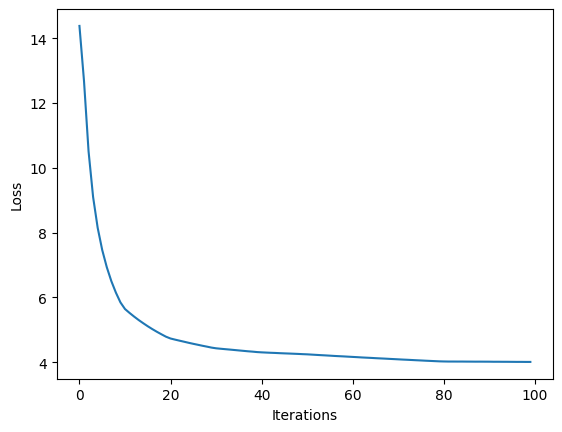

In [10]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# save as .png file
plt.savefig('./results/sgns-full/case3/losses.png')

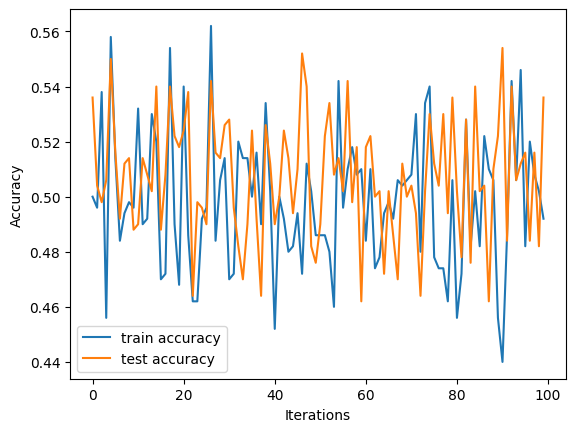

In [11]:
# plot training accuracy and test accuracy on the same plot
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

# save as .png file
plt.savefig('./results/sgns-full/case3/accuracy.png')

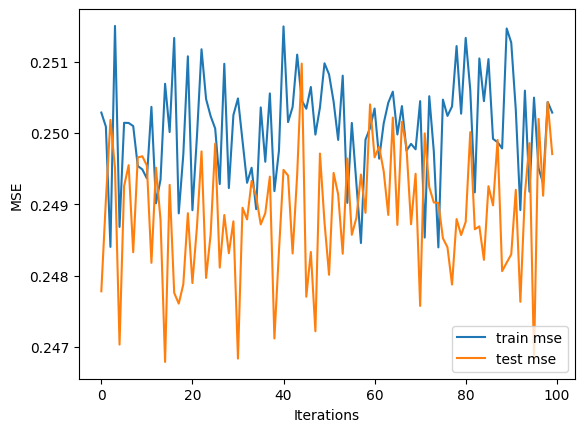

In [12]:
# plot training and test mse on the same plot
plt.plot(train_mses, label='train mse')
plt.plot(test_mses, label='test mse')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

# save as .png file
plt.savefig('./results/sgns-full/case3/mse.png')

In [13]:
# copy U and V
V_trained = np.copy(params[0][0])
U_trained = np.copy(params[0][1])

# check dimensions of U and V
print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 14119)
U_trained shape: (14119, 300)


In [14]:
# evaluate the final model
# train accuracy and mse
train_mse, train_accuracy = evaluate_model(V_trained, targets_train, contexts_train, labels_train, num_samples=len(targets_train))
print(f'train mse: {train_mse:.4f}')
print(f'train accuracy: {train_accuracy:.4f}')

# test accuracy and mse
test_mse, test_accuracy = evaluate_model(V_trained, targets_test, contexts_test, labels_test, num_samples=len(targets_test))
print(f'test mse: {test_mse:.4f}')
print(f'test accuracy: {test_accuracy:.4f}')

train mse: 0.0231
train accuracy: 0.9906
test mse: 0.1499
test accuracy: 0.7310


In [15]:
# given epoch_losses, train_mses, train_accuracies, test_mses, test_accuracies
x = np.arange(n_epochs)
results = {'epoch': x, 'epoch_losses': epoch_losses, 'train_mses': train_mses, 'train_accuracies': train_accuracies, 'test_mses': test_mses, 'test_accuracies': test_accuracies}

In [16]:
# save all the results
# save V_trained, U_trained as csv files
np.savetxt('./results/sgns-full/case3/V_trained.csv', V_trained, delimiter=',')
np.savetxt('./results/sgns-full/case3/U_trained.csv', U_trained, delimiter=',')

# save results as csv file
results_df = pd.DataFrame(results)
results_df.to_csv('./results/sgns-full/case3/results.csv', index=False)
results_df.head()

,epoch,epoch_losses,train_mses,train_accuracies,test_mses,test_accuracies
0,0,14.378534,0.25028476,0.500,0.24778019,0.536
1,1,12.679022,0.2500877,0.496,0.24905844,0.504
2,2,10.508759,0.24840215,0.538,0.25018173,0.498
3,3,9.094916,0.2514988,0.456,0.24950969,0.506
4,4,8.147986,0.24868235,0.558,0.24703312,0.550
